In [203]:
import numpy as np
import pandas as pd
import math
import operator
import random
import matplotlib.pyplot as plt
from numpy import linalg as LA
from copy import deepcopy
from sklearn import mixture
from sklearn.cluster import AgglomerativeClustering

In [204]:
def get_test_train(location):
    location = '~/Documents/SMAI/Assignment3/' + location
    dataframe = pd.read_csv(location,header=None)
    #dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    train  = dataframe[:int(0.8*len(dataframe))]
    test = dataframe[int(0.8*len(dataframe)):]
    return test,train

In [205]:
def get_test_train_with_header(location):
    location = '~/Documents/SMAI/Assignment3/' + location
    dataframe = pd.read_csv(location)
    #dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    train  = dataframe[:int(0.8*len(dataframe))]
    test = dataframe[int(0.8*len(dataframe)):]
    return dataframe,test,train

In [206]:
def getXY(location):
    location = '~/Documents/SMAI/Assignment3/' + location
    dataframe = pd.read_csv(location)
    X = dataframe.values[:,:-1]
    Y = dataframe.values[:,-1]
    return X,Y

## PCA

PCA is used for dimensionality reduction.

<b>Algorithm</b>

1. Standardize the data.
2. Obtain the Eigenvectors and Eigenvalues from the covariance matrix or correlation matrix, or perform Singular Vector Decomposition.
3. Sort eigenvalues in descending order and choose the k eigenvectors that correspond to the k largest eigenvalues where k is the number of dimensions of the new feature subspace (k≤d).
4. Construct the projection matrix W from the selected k eigenvectors.
5. Transform the original dataset X via W to obtain a k-dimensional feature subspace Y.


In [207]:
def PCA(X):
    Z = np.array(X.copy())
    #Standardize
    for col in range(0,Z.shape[1]):
        Z.T[col] = (Z.T[col] - np.mean(Z.T[col]))/np.std(Z.T[col]) 
    #print(Z)
    #Find Covariance
    
    cov = np.cov(Z.T.astype(float))
    eigval,eigvect = LA.eig(cov)
    #print(eigval)
    #Sort eigen values
    eigvalvect = [[np.abs(eigval[i]),eigvect.T[i]] for i in range(0,eigval.shape[0])]
    #print(eigvalvect)
    eigvalvect.sort(key=lambda x:x[0],reverse=True)
    neweigvect = []
    for i in range (0,eigval.shape[0]):
        neweigvect.append(eigvalvect[i][1])
    neweigvect = np.array(neweigvect) #ordered eigen vector
    
    #Finding K with 10% error
    eigvalsum = sum(eigval)
    s=0
    k=0

    for i in range(0,eigval.shape[0]):
        s+=eigvalvect[i][0]/eigvalsum
        if s < 0.9:
            k+=1  
        #print(s)    
    #print(k+1)
    
    '''
    eignormlist = []
    Klist = []
    for i in range(0,eigval.shape[0]):
        eignormlist.append(eigvalvect[i][0]/eigvalsum)
        k+=1
        Klist.append(k)
    plt.plot(Klist,eignormlist,c='r')
    plt.show()
    '''
    #print(X.shape)
    #print(np.array(neweigvect[:k+1]).shape)
    projected_data = Z.dot(np.array(neweigvect[:k+1]).T)
    #print(neweigvect[:K+1])
    #print(projected_data)
    return(projected_data)

## K-Means

K-means clustering is a type of unsupervised learning, which is used when you have unlabeled data (i.e., data without defined categories or groups). The goal of this algorithm is to find groups in the data, with the number of groups represented by the variable K. The algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on feature similarity. The results of the K-means clustering algorithm are:

The centroids of the K clusters, which can be used to label new data
Labels for the training data (each data point is assigned to a single cluster)


### Algorithm

1. Assign random points to the k clusters.
2. For a data point, find it's distance from eack k clusters.
3. Assign the datapoint to it's nearest cluster.
4. Repeat steps 2 and 3 until no assignment of datapoints to clusters changes

In [208]:
def KMeans(data,k):
    KPoints = {}
    Kval = {}
    KPointsRowNum = {}
    for i in range(0,k):
        KPoints[i] = []
        KPointsRowNum[i] = []
        Kval[i] = []
        
    #initialize clusters at random points (at some given point)
    for key in Kval:
        row = random.randint(0,data.shape[0])
        for j in data[row]:
            Kval[key].append(random.uniform(0,1))  
            #Kval[key].append(j)  #A random point in the dataset is the cluster's position
    print("C-1")
    #for each row
    #  find the distane to each cluster
    #  the closest cluster (least distance gets the row)
    
    #for each cluster 
    #  find the mean of the points in that cluster
    #  change the position of the cluster
    
    KPointsRowNumCopy = {}
    count=1
    #while count<=20:
    while KPointsRowNumCopy != KPointsRowNum:
        print(count)
        KPointsRowNumCopy = deepcopy(KPointsRowNum)
        for K in KPoints:
            KPoints[K] = []
            KPointsRowNum[K] = []
        #print("C0")
        
        for row in range(0,data.shape[0]):
            
            distlist = []
            for K in Kval:
                center = Kval[K]
                #data[row] and center
                dist = 0
                for attribute in range(0,len(data[row])):
                    dist+=(pow(abs(data[row][attribute] - center[attribute]),2))
                dist=math.sqrt(dist)
                distlist.append(dist)
            minclust = np.argmin(distlist)
            KPoints[minclust].append(data[row])
            KPointsRowNum[minclust].append(row)
            
        #print("C1")
        
        for K in KPoints:
            mat = np.array(KPoints[K]).T
            for i in range(0,len(Kval[K])):
                Kval[K][i] = np.sum(mat[i])/len(mat[i])
        #print("C2")
        
        count+=1
    return KPointsRowNum 
    

In [209]:
def findLabel(CalculatedCluster,NewData,Y):
    clusterLabelCount = {}
    clusterLabel = {}
    clusterDataSize = {}
    distinctLabels = np.unique(np.array(Y))
    for key in CalculatedCluster:
        #key is some cluster here.
        clusterLabelCount[key] = {}
        clusterLabel[key] = ''
        #clusterDataSize has the count of element in every cluster
        clusterDataSize[key] = len(CalculatedCluster[key])
        
        for lab in distinctLabels:
            #will have count of every label in a cluster.To be used to find ratio and assign a cluster name .
            clusterLabelCount[key][lab] = 0
    
    for key in CalculatedCluster:
        for row in CalculatedCluster[key]:
            clusterLabelCount[key][Y[row]]+=1
        clusterLabel[key] = sorted(clusterLabelCount[key].items(),key = lambda arg:arg[1],reverse=True)[0][0]
    
    #print(clusterLabel)  #Adds a label to a cluster
    #print(clusterLabelCount)  #Has the count of all data points in cluster
    
    
    return(clusterLabel,clusterLabelCount,clusterDataSize)
    


## Logistic Regression

Logistic Regression measures the relationship between the dependent variable (our label, what we want to predict) and the one or more independent variables (our features), by estimating probabilities using it’s underlying logistic function.

These probabilities must then be transformed into binary values in order to actually make a prediction. This is the task of the logistic function, also called the sigmoid function. The Sigmoid-Function is an S-shaped curve that can take any real-valued number and map it into a value between the range of 0 and 1, but never exactly at those limits. This values between 0 and 1 will then be transformed into either 0 or 1 using a threshold classifier.

### Algorithm

1. Initially, random slopes with respect to number of features is considered. It could be any number.<br><br>

2. Another matrix is considered which is the collection of features and it's values. This, with the slopes above tells you about a random line on a 2D plane. We have to use this line and the data pints in the data space to fit the line in such a away that it seperates two classes as much as possible<br><br>

3. Use Sigmoid Function to convert any numbers to probabilities<br><br>

4. Using gradient descent, we can minimize the error such that our slope that seperates our classes.
   We continur this until our error funcion hits a minima.<br><br>
5. Now we can test our accuracy

In [210]:
'''
USED IN Logistic REGRESSION
'''
def sigmoid(B,X):
    return 1/(1+np.exp(-1*(X.dot(B))))

### Gradient Descent

$\beta_i = \beta_i - \alpha\ast\dfrac{1}{m}\sum_{m \in M}(\beta_i^TX_m - Y)X_i $ <br>

where $X_i$ is the gradient, $\beta_i^TX$ is the hypothesis, $Y$ is the true value and $\beta_i$ is the slope of the $i^{th}$ feature. This step updates the slope by calculating the new slope by minimizing cost by differentiating one of the cost functions above. 

In [211]:
'''
USED IN Logistic REGRESSION
'''
def gradient_descent(X,B,Y,alpha):
    m = len(Y)
    cost = 0
    for i in range(0,500):
        #print(B)
        B -= alpha*(1/m)*(X.T.dot((sigmoid(B,X) - Y)))/2
        #cost = cost_function(X,B,Y)
        #print(cost)
    return B

In [212]:
'''
USED IN Logistic REGRESSION
'''
def predictLinear(dataframe,test,target,B,multi=False,threshold=0.5):
    X = []
    x0 = np.ones(test.shape[0])
    columns = list(test.columns)
    columns.pop(0)
    X.append(list(x0))
    for col in columns:
        if col!= target:
            #print(col)
            normalized_col = list(((test[col].values) - np.mean(dataframe[col].values))/np.std(dataframe[col].values))
            X.append(normalized_col)
    
    X = np.array(X).T
    Y = np.array(test[target].values)
    if multi is True:
        predicted_y = sigmoid(B,X)
    else:
        predicted_y = sigmoid(B,X)>=threshold
    return X,predicted_y

In [213]:
'''
USED IN Logistic REGRESSION
'''
def LogisticRegressionFit(dataframe,test,train,target):
    #get X matrx which consists all features
    X = []
    x0 = np.ones(train.shape[0])
    columns = list(train.columns)
    columns.pop(0)
    X.append(list(x0))
    for col in columns:
        if col!= target:
            #print(col)
            normalized_col = list(((train[col].values) - np.mean(dataframe[col].values))/np.std(dataframe[col].values))
            X.append(normalized_col)
    
    X = np.array(X).T
    #X = np.array(X)
    B = np.array(np.zeros(len(columns)))
    Y = np.array(train[target].values)
    alpha = 0.1
    #B = Y.T.dot(np.linalg.inv(X.T.dot(X)).dot(X.T))
    #print(X.shape,B.shape,Y.shape)
    B = gradient_descent(X,B,Y,alpha)
    return(B)

### Prediction (Binary label)

The function <b>BinaryMeasure()</b> is the function that <b>predicts</b> the value for a test set. 

#### Formula to calculate Accuracy, Precision, Recall and F-Score:

<b>Accuracy</b> = $\dfrac{TP + TN}{TP+TN+FP+FN}$ <br><br>
<b>Precision</b> = $\dfrac{TP}{TP+FP}$<br><br>
<b>Recall</b> = $\dfrac{TP}{TP+FN}$<br><br>
<b>F-Score</b> = $\dfrac{2}{(\dfrac{1}{Recall}+\dfrac{1}{Precision})}$<br><br>

where <b>TP</b> = True Positive,<br><b>TN</b> = True Negative,<br><b>FP</b> = False Positive,<br><b>FN</b> = False Negative

In [214]:
def BinaryMeasure(predicted_y,test,target,multi=False,threshold=0.5):
    j = 0
    TN=0
    TP=0
    FN=0
    FP=0
    #print(test[target].values)
    if multi is True:
        target_col = (test[target].values)
        for i in predicted_y:
            if i == target_col[j]:
                TP+=1
            j+=1
        accuracy = TP/len(test[target])
        precision = 0
        recall = 0
    else:
        target_col = (test[target].values)>=threshold
        #print(target_col)
        #print(predicted_y,target_col)
        for i in predicted_y:
            #print(j,target)
            if i==0 and i == target_col[j]:
                TN+=1
            elif i==0 and i!= target_col[j]:
                FN+=1
            elif i==1 and i == target_col[j]:
                TP+=1
            elif i==1 and i!= target_col[j]:
                FP+=1
            j+=1
    
        #print(TP,TN,FP,FN)
        accuracy =  (TP+TN)/(TP+TN+FP+FN)
        precision = (TP)/(TP+FP+np.finfo(float).eps)
        recall = (TP)/(TP+FN+np.finfo(float).eps)
        #fscore = 2/((1/precision)+(1/recall))
    return accuracy,precision,recall

##   K- Nearest Neighbour (KNN)
KNN is one of the most simplest to implement algorithms in Machine Learning. It deals with calculating       distance (of a new data point) with respect to all other data points and finds K nearest neighbout to classify in of the labels.

An advantage of KNN is that there is no actual training done unlike other machine learning algorithms. More details mentioned in the algorithm below.

### Algorithm
1. For every new data point, find the distance between each anad every other already existing data points and    store in a list. The distance can be found by minkowski measure which is discussed in the next segment.<br><br>

2. Once distance of a data point from all other data points is found, find those 'K' elements which are          nearest to the data point in question. This can be found by sorting the list of distances. The most            efficient way to sort is using a heap. For simplicity we have used a list.<br><br>

3. Among the 'K' nearest points, find the most frequently occuring label and classify the unknown data point      to that label.

The below function <b>KNN()</b> does the above mentioned steps. 

### Minkowski Distance

The minkowski distance is of the form : $(\sum_{i \in R}|x_i - t_i|^{p})^{1/p}$ where <b>R</b> is a row which represents a data point and <b>i</b> is each field in the row, <b>x</b> is an already data point and <b>t</b> is a new data point to be classified.

It is important to note that Minkowski is a generalized distnace formula.The value <b>p</b> defines which distance is used. when <b>p</b> equals 1, it is known as <b>Euclidian Distance</b>.

When <b>p</b> equals 2, it is known as <b>Manhattan distance</b>. We have used only these two measures however there are many more distnace metrics out of the Minkowski distance. <b>minkowski_predict</b> calculates the above expression

In [215]:
'''
USED IN KNN
'''
def minkowski_predict(test_row,train_row,power,target):
    dist = 0
    #print(test_row,train_row,power,target)
    for attribute in range(0,len(test_row)):
        if attribute != target:
            dist+=(pow(abs(test_row[attribute] - train_row[attribute]),power))
    return pow(dist,1/power)

In [216]:
'''
USED IN KNN
'''
def getsecond(item):
    return item[1]


def KNN(test,train,K,dist_measure,target):
    unique_values = np.unique(train.values[:,target])
    maxval = -1
    winner = None
    class_dict = {}
    for classVal in unique_values:
        class_dict[classVal] = 0
  
    if dist_measure == 'euclid':
        power = 2
    elif dist_measure == 'man':
        power = 1
    predicted = []
    for test_row in test.values:
        #print(test_row)
        knn = []
        maxval = -1
        winner = None
        for train_row in train.values:
            #print(train_row)
            #print(test_row)
            y = minkowski_predict(test_row,train_row,power,target)
            #print(y)
            knn.append((train_row[target],y))
        knn.sort(key = getsecond)
        
        #print(knn)
        for i in range(0,K):
            class_dict[knn[i][0]]+=1
            #if class_dict[knn[i][0]] > maxval:
            #    winner = knn[i][0]
            #    maxval = class_dict[knn[i][0]]
        winner = max(class_dict.items(),key=operator.itemgetter(1))[0]    
        predicted.append(winner)
        #print(class_dict)
        for classVal in unique_values:
            class_dict[classVal] = 0
    return predicted        

## Question 1
### Part-1

In [217]:
location = 'intrusion_detection/data.csv'
X,Y = getXY(location)
NewData = PCA(X)

### Part-2

In [218]:
#Continued from part-1
CalculatedCluster = KMeans(NewData,5)

#print(len(CalculatedCluster[0]))
#print(len(CalculatedCluster[1]))
#print(len(CalculatedCluster[2]))
#print(len(CalculatedCluster[3]))
#print(len(CalculatedCluster[4]))


C-1
1
2
3
4
5
6
7
8
9
10
11


In [219]:
clusterLabel,clusterLabelCountKmeans,clusterDataSize = findLabel(CalculatedCluster,NewData,Y)
#print(clusterLabelCount)
maxkmeans=0
totalpoints=0
print("Individual Cluster Purity")
print("==========================")
for key in clusterLabel:
    print(clusterLabel[key])
    print(clusterLabelCountKmeans[key][clusterLabel[key]]/clusterDataSize[key])
    maxkmeans+=clusterLabelCountKmeans[key][clusterLabel[key]]
    print("\n")
#print(CalculatedCluster)
for key in clusterDataSize:
    totalpoints+=clusterDataSize[key]
puritykmeans = maxkmeans/totalpoints
print("Total Purity: ",puritykmeans)

Individual Cluster Purity
probe
0.8175473579262214


normal
0.733222407099279


normal
0.9210718635809988


dos
0.9839502602660497


dos
0.4606551840594394


Total Purity:  0.8662292983438675


### Part-3

In [220]:
#PCA, X and Y are defined from PArt-1. Run Part-1 before running this
gmm = mixture.GaussianMixture(n_components=5)
gmm.fit(NewData)
labels = gmm.predict(NewData)
dictrowgmm = {}
for i in range(0,5):
    dictrowgmm[i] = []
for i in range(0,len(labels)):
    dictrowgmm[labels[i]].append(i)

clusterLabel,clusterLabelCountGmm,clusterDataSize = findLabel(dictrowgmm,NewData,Y) 
#print(clusterLabelCount)
maxGmm=0
totalpoints=0
print("Individual Cluster Purity")
print("==========================")
for key in clusterLabel:
    print(clusterLabel[key])
    print(clusterLabelCountGmm[key][clusterLabel[key]]/clusterDataSize[key])
    maxGmm+=clusterLabelCountGmm[key][clusterLabel[key]]
    print("\n")
#print(CalculatedCluster)
for key in clusterDataSize:
    totalpoints+=clusterDataSize[key]
purityGmm = maxGmm/totalpoints
print("Total Purity: ",purityGmm)


Individual Cluster Purity
dos
1.0


normal
0.5339130434782609


normal
0.7500154655119085


probe
1.0


normal
0.8571428571428571


Total Purity:  0.7953836306904553


### Part-4

In [221]:
#PCA, X and Y are defined from PArt-1. Run Part-1 before running this
clt = AgglomerativeClustering(linkage='single', 
                              affinity='euclidean', 
                              n_clusters=5)
model = clt.fit(NewData)
labels = model.labels_
dictrowAgg = {}
for i in range(0,5):
    dictrowAgg[i] = []
for i in range(0,len(labels)):
    dictrowAgg[labels[i]].append(i)

clusterLabel,clusterLabelCountAgg,clusterDataSize = findLabel(dictrowAgg,NewData,Y) 
#print(clusterLabelCount)
maxAgg=0
totalpoints=0
print("Individual Cluster Purity")
print("==========================")
for key in clusterLabel:
    print(clusterLabel[key])
    print(clusterLabelCountAgg[key][clusterLabel[key]]/clusterDataSize[key])
    maxAgg+=clusterLabelCountAgg[key][clusterLabel[key]]
    print("\n")
#print(CalculatedCluster)
for key in clusterDataSize:
    totalpoints+=clusterDataSize[key]
purityAgg = maxAgg/totalpoints
print("Total Purity: ",purityAgg)

Individual Cluster Purity
normal
0.5346352395053824


probe
1.0


r2l
0.6666666666666666


normal
1.0


normal
1.0


Total Purity:  0.5347227778222258


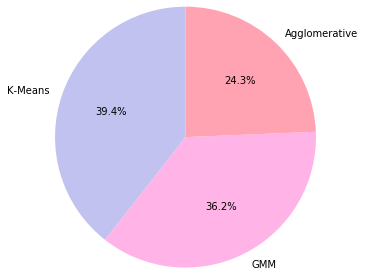

In [224]:
## Make sure to run all the above code first.
labels = ['K-Means', 'GMM', 'Agglomerative']
sizes = [puritykmeans,purityGmm,purityAgg]
colors = ['#ff6666', '#ffcc99', '#99ff99']
clusterLabelCount = {}

plt.pie(sizes, labels=labels, autopct='%1.1f%%',colors=colors_in,radius = 1.5,startangle=90)
plt.show()

### Part-5

Generally PCA is used for continuous variables. This is becuase we need to calculate strandard deviation and mean to standardize the data. If we use this in a categorical variable, it becomes difficult to standardize the data. Thus the challenge here is to find a mechanism to make these a continuous types maybe by uisng distance formulas. 

## Question -2

### Part-1

In [45]:
location = 'AdmissionDataset/data.csv'
dataframe,test,train = get_test_train_with_header(location)
target = 'Chance of Admit'
slopeValues = LogisticRegressionFit(dataframe,test,train,target)
X,predicted_y = predictLinear(dataframe,test,target,slopeValues)
accuracy,precision,recall = BinaryMeasure(predicted_y,test,target)
print(accuracy)

0.9555555555555556


### Part-2

In [41]:
location = 'AdmissionDataset/data.csv'
dataframe,test,train = get_test_train_with_header(location)
test = pd.DataFrame(np.delete(test.values,0,1))
train = pd.DataFrame(np.delete(train.values,0,1))
K = 7
target = 7
#print(test.values)
train.values.T[-1] = np.array(train.values.T[-1])>=0.5
test.values.T[-1] = np.array(test.values.T[-1])>=0.5
#print(test.values.T[-1])
predicted_y = KNN(test,train,K,'euclid',target)
#print(predicted_y)
#test.values[target] = np.array(test.values[target])>=0.5
accuracy,precision,recall = BinaryMeasure(np.array(predicted_y)>=0.5,test,target)
#print("Robot1")
print("===================================")
print("Accuracy = ",accuracy)
print("Precision = ",precision)
print("Recall = ",recall)


Accuracy =  0.9444444444444444
Precision =  0.9418604651162791
Recall =  1.0


### Part-3

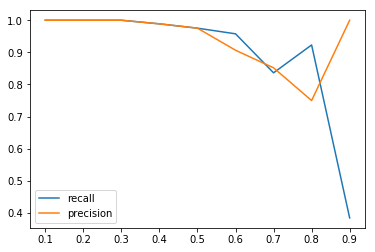

In [56]:
location = 'AdmissionDataset/data.csv'
dataframe,test,train = get_test_train_with_header(location)
target = 'Chance of Admit'
problist = []
precisionlist = []
recallist = []
prob = 1
while prob < 10:
    slopeValues = LogisticRegressionFit(dataframe,test,train,target)
    X,predicted_y = predictLinear(dataframe,test,target,slopeValues,False,prob/10)
    accuracy,precision,recall = BinaryMeasure(predicted_y,test,target,False,prob/10)
    problist.append(prob/10)
    precisionlist.append(precision)
    recallist.append(recall)
    prob+=1
plt.plot(problist,recallist,label='recall')
plt.plot(problist,precisionlist,label='precision')
plt.xlabel = 'threshold'
plt.ylabel = 'measure'
plt.legend()
plt.show()

One important criteria to choose a threshold is to clearly divide the values such that they can be classified in a binary way. Thus we must choose a threshold with least bias i.e middle most of any range. Since probabilities range between 0 and 1, 0.5 is a good threshold to choose (which is also been chosen in this project)  

## Question -3

### One-All

In [222]:
location = 'wine-quality/data.csv'
dataframe,test,train = get_test_train_with_header(location)
#print(test)
testcopy = test.copy()
traincopy = train.copy()
target = 'quality'
unique_class = np.unique(np.array(train[target]))
labpred = []
labdict = {}
true_predicted = []
z = 0
for key in unique_class:
    labdict[z] = key
    z+=1
#print(labdict)
for c in unique_class:
    train[target] = (train[target].values) == c
    test[target] = (test[target].values) == c
    slopeValues = LogisticRegressionFit(dataframe,test,train,target)
    #print(slopeValues)
    X,predicted_y = predictLinear(dataframe,test,target,slopeValues,True)
    labpred.append(predicted_y)
    train = traincopy.copy()
    test = testcopy.copy()
    #print(predicted_y)
    #print(test[target].values)
labpred = np.array(labpred)
#print(labpred)
for row in range(0,len(testcopy[target])):
    true_predicted.append(labdict[(np.argmax(labpred[:,row]))])
#print(true_predicted)
#print(testcopy[target])
accuracy,precision,recall = BinaryMeasure(true_predicted,testcopy,target,True)
print(accuracy)

/home/yash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/yash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.5374149659863946


### One-One

In [201]:
location = 'wine-quality/data.csv'
dataframe,test,train = get_test_train_with_header(location)
#print(test)
testcopy = test.copy()
traincopy = train.copy()
target = 'quality'
unique_class = np.unique(np.array(train[target]))
labpred = []
labdict = {}
true_predicted = []
z = 0
for key in unique_class:
    labdict[z] = key
    z+=1
    
for c1_ind in range(0,len(unique_class)):
    for c2_ind in range(c1_ind,len(unique_class)):
        if unique_class[c1_ind]!=unique_class[c2_ind]:
            train = train[(train[target] == unique_class[c1_ind]) | (train[target] == unique_class[c2_ind])]
            train = test[(test[target] == unique_class[c1_ind]) | (test[target] == unique_class[c2_ind])]
            #print(train)
            train[target] = (train[target].values) == unique_class[c1_ind]
            test[target] = (test[target].values) == unique_class[c1_ind]
            slopeValues = LogisticRegressionFit(dataframe,test,train,target)
            X,predicted_y = predictLinear(dataframe,test,target,slopeValues,True)
            for val in range(0,len(predicted_y)):
                if predicted_y[val] >= 0.5:
                    predicted_y[val] = unique_class[c1_ind]
                else:
                    predicted_y[val] = unique_class[c2_ind]
            labpred.append(predicted_y)
            train = traincopy.copy()
            test = testcopy.copy()
            #print(predicted_y)
            #print(test[target].values)
labpred = np.array(labpred)
predarr = []
for row in range(0,len(testcopy[target])):
    #print(row)
    col = []
    col.extend(labpred[:,row])
    count = max(col,key=col.count)
    true_predicted.append(count)
    #true_predicted.append(labdict[(np.argmax(labpred[:,row]))]) 
accuracy,precision,recall = BinaryMeasure(true_predicted,testcopy,target,True)
print(accuracy)

/home/yash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/yash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.5272108843537415


With respect to our accuracies above, there are two observations.
1. We may need another way to predict multi class variables.
2. Our model is underfit thereby may need more data to train.